# Detect sarcasm in the news

## 1.0 Problem and purpose
Disinformation causes confusion and costs time and money for businesses and information consumers alike. One way to address this educating oruselves to critically consider the source, contents, and authors of the information we receive. Another way is to employ an army of sorters. As you can imagine, there are obvious limitations and additional steps we can take to address the problem.

The purpose of this case study is to build a model that identifies sarcasm in the written news articles. This tool can help reduce the spread of fake news by filtering out possible sarcasm. This is an interesting project because it can help reduce confusion and costs associated with misinformation.

## 2.0 Dataset(s)
The dataset contains news headlines from HuffPost, for non-sarcastic news, and  TheOnion, for sarcastic news. The dataset is comprised of:

* 26,709 records
* 3 attributes including the label, the headline text, and the link to the article
* the binary label called "is_sarcastic" which indicates whether the example is sarcastic


## 3.0 Challenges and approach

Twitter is a common source of data for sarcasm but for now we move away from the informal language, shortened syntax, hashtags, and common spelling mistakes. We are going to use self-contained news headlines so we can flesh out truly sarcastic elements in a given statement. By using headlines, we mitigate sparsity and increase the chance of finding pre-trained embeddings.

## 4.0 Implementation

In [32]:
# Set-up libraries
import os
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow import keras

In [33]:
# Check source
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json
../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json


In [34]:
# Load data
df = pd.read_json('../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json', lines=True)

print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26709 non-null  object
 1   headline      26709 non-null  object
 2   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 626.1+ KB
None
                                        article_link  \
0  https://www.huffingtonpost.com/entry/versace-b...   
1  https://www.huffingtonpost.com/entry/roseanne-...   
2  https://local.theonion.com/mom-starting-to-fea...   
3  https://politics.theonion.com/boehner-just-wan...   
4  https://www.huffingtonpost.com/entry/jk-rowlin...   

                                            headline  is_sarcastic  
0  former versace store clerk sues over secret 'b...             0  
1  the 'roseanne' revival catches up to our thorn...             0  
2  mom starting to fear son's web series closest ...             1  
3  boehner j

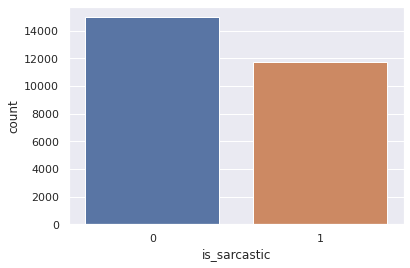

In [35]:
# Explore label breakdown
df['is_sarcastic'].value_counts()
sns.countplot(df['is_sarcastic'])

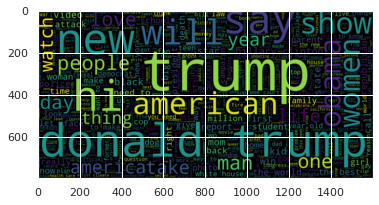

In [36]:
# Explore non-sarcastic headlines quickly
wc = WordCloud(max_words=1000, 
               width=1600, 
               height=800).generate(" ".join(df[df.is_sarcastic==0].headline))
plt.imshow(wc, interpolation='bilinear')

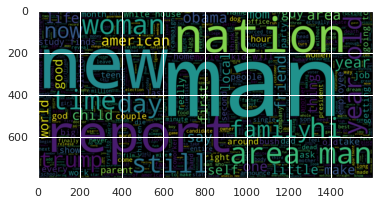

In [37]:
# Explore non-sarcastic headlines quickly
wc = WordCloud(max_words=1000, 
               width=1600, 
               height=800).generate(" ".join(df[df.is_sarcastic==1].headline))
plt.imshow(wc, interpolation='bilinear')

In [38]:
# Split data into 80% training and 20% validation
sentences = df['headline']
labels = df['is_sarcastic']

train_sentences, val_sentences, train_labels, val_labels = train_test_split(sentences, labels, test_size=0.2, random_state=0)

print(train_sentences.shape)
print(val_sentences.shape)
print(train_labels.shape)
print(val_labels.shape)

(21367,)
(5342,)
(21367,)
(5342,)


In [39]:
# Tokenize and pad
vocab_size = 10000
oov_token = '<00V>'
max_length = 100
padding_type = 'post'
trunc_type = 'post'


tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

val_sequences = tokenizer.texts_to_sequences(val_sentences)
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [40]:
# Build and train neural network
embedding_dim = 16
num_epochs = 10
batch_size = 100

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy']
             )

history = model.fit(train_padded, train_labels, batch_size=batch_size, epochs=num_epochs, 
                    verbose=2)

Train on 21367 samples
Epoch 1/10
21367/21367 - 1s - loss: 0.6844 - accuracy: 0.5579
Epoch 2/10
21367/21367 - 1s - loss: 0.6436 - accuracy: 0.6002
Epoch 3/10
21367/21367 - 1s - loss: 0.4734 - accuracy: 0.8204
Epoch 4/10
21367/21367 - 1s - loss: 0.3441 - accuracy: 0.8716
Epoch 5/10
21367/21367 - 1s - loss: 0.2885 - accuracy: 0.8903
Epoch 6/10
21367/21367 - 1s - loss: 0.2543 - accuracy: 0.9032
Epoch 7/10
21367/21367 - 1s - loss: 0.2298 - accuracy: 0.9156
Epoch 8/10
21367/21367 - 1s - loss: 0.2091 - accuracy: 0.9241
Epoch 9/10
21367/21367 - 1s - loss: 0.1918 - accuracy: 0.9315
Epoch 10/10
21367/21367 - 1s - loss: 0.1773 - accuracy: 0.9358


## 5.0 Results discussion

We achieved a validation accuracy of 85% by training the model on 21367 samples in 10 epochs. We leveraged an architecture of an embedding layer, pooling layer, a dense layer with 24 neurons and an activation function of relu, and a sigmoid-activated layer at the end. This is a fast and simple approach that yielded 3 out of 3 correct responses when we gave the model three test statements.

## 6.0 Conclusion

Case study summary

In this case study, we designed, built, and trained a simple neural network to detect sarcasm in news headlines. We chose news headlines as opposed to Twitter for a number of reasons including reduction of sparsity and self-containment. 


Future directions

The model is not limited to news headlines. We can train it further to detect sarcastic product reviews and social media statements. I think another important application of the model, and NLP in general, is detecting toxic or bully comments on virtual communities. In the future, we can perhaps use the technology to flag discriminating, patronizing, or otherwise demeaning comments in real-time conversations, virtual or physical. 

Real-world retrospective

There are many ways to approach the problem of disinformation. Readers, producers, and dissiminators of information are equally responsible for verifying the veracity of the information. In addition, technology has come as far as the point of automating many painstaking processes, including sarcasm detection. 

## 7.0 References

Misra, R., Arora, P. (2019) 'Sarcasm Detection using Hybrid Neural Network', *arXiv*. Available at: https://arxiv.org/pdf/1908.07414.pdf. doi: 	10.13140/RG.2.2.32427.39204.